# PoC on German Credit

In [176]:
%reload_ext autoreload
%autoreload 2

## Data Processing

In [177]:
import pandas as pd

data = pd.read_csv('data/german_credit.csv')
# data = data.drop('Checking account', axis=1)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [178]:
data['Sex'].value_counts()

Sex
male      690
female    310
Name: count, dtype: int64

## Model Training

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

target_name = 'Risk'

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split the data into features and target variable
X = data.drop(target_name, axis=1)
y = data[target_name]

# Split the data into training and testing sets
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.7, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)


In [174]:
a_train = X_train['Sex']
a_test = X_test['Sex']
a_train_full = X_train_full['Sex']
a_test_full = X_test_full['Sex']


In [ ]:
# make sure gender is balanced
import random
index_0 = X_train_full.index[X_train_full['Sex'] == 0].tolist()
index_1 = X_train_full.index[X_train_full['Sex'] == 1].tolist()
selected_index_1 = random.sample(index_1, 254)
X_train_full_balance_gender = pd.concat([X_train_full.loc[index_0], X_train_full.loc[selected_index_1]])
y_train_full_balance_gender = pd.concat([y_train_full.loc[index_0], y_train_full.loc[selected_index_1]])
a_train_balance_gender = pd.concat([a_train_full.loc[index_0], a_train_full.loc[selected_index_1]])

print(len(selected_index_1))
print(X_train_full_balance_gender.shape)

In [16]:
index_0 = X_test_full.index[X_test_full['Sex'] == 0].tolist()
index_1 = X_test_full.index[X_test_full['Sex'] == 1].tolist()
selected_index_1 = random.sample(index_1, 56)
X_test_full_balance_gender = pd.concat([X_test_full.loc[index_0], X_test_full.loc[selected_index_1]])
y_test_full_balance_gender = pd.concat([y_test_full.loc[index_0], y_test_full.loc[selected_index_1]])
a_test_balance_gender = pd.concat([a_test_full.loc[index_0], a_test_full.loc[selected_index_1]])


In [ ]:
X_test_full_balance_gender.shape

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy = {accuracy}')
print(report)

Accuracy = 0.6833333333333333
              precision    recall  f1-score   support

           0       0.67      0.27      0.39        22
           1       0.69      0.92      0.79        38

    accuracy                           0.68        60
   macro avg       0.68      0.60      0.59        60
weighted avg       0.68      0.68      0.64        60



c:\Users\ZhuLi\anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# train the full dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the logistic regression model
model_full = LogisticRegression(max_iter=1000)
model_full.fit(X_train_full, y_train_full)

# Predict on the test set
y_pred_full = model_full.predict(X_test_full)

# Evaluate the model
accuracy = accuracy_score(y_test_full, y_pred_full)
print(f'Accuracy = {accuracy}')

In [ ]:
# train the full dataset with balance gender
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the logistic regression model
model_full_balance_gender = LogisticRegression(max_iter=1000)
model_full_balance_gender.fit(X_train_full_balance_gender, y_train_full_balance_gender)

# Predict on the test set
y_pred_full_balance_gender = model_full_balance_gender.predict(X_test_full_balance_gender)

# Evaluate the model
accuracy = accuracy_score(y_test_full_balance_gender, y_pred_full_balance_gender)
print(f'Accuracy = {accuracy}')

## Fairness Checking (Naive)

In [181]:
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'false_positive_rate': false_positive_rate,
           'true_positive_rate': true_positive_rate,
           'false_negative_rate': false_negative_rate,
           'true_negative_rate': true_negative_rate,
              'count': count}

Test set fairness metrics (before mitigation):


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
Sex,,,,,,,
0,0.750000,0.750000,0.500000,0.875000,0.125000,0.500000,24.0
1,0.638889,0.916667,0.857143,0.954545,0.045455,0.142857,36.0


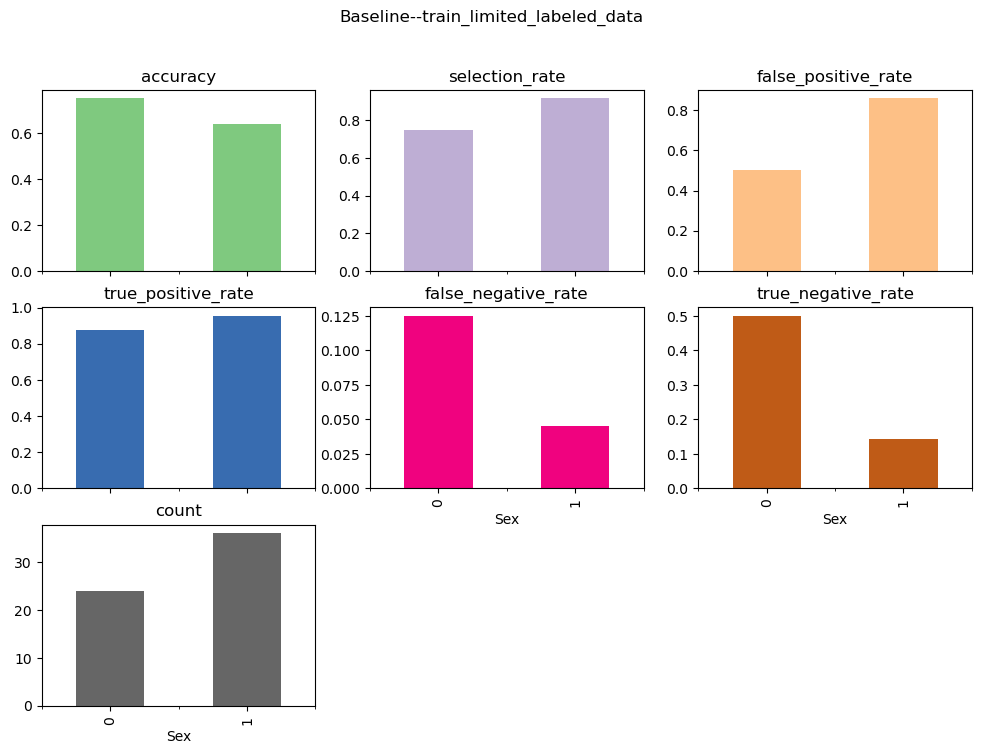

In [216]:
mf_original = MetricFrame(metrics=metrics,
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=a_test)

print("Test set fairness metrics (before mitigation):")
mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Baseline--train_limited_labeled_data",
)
mf_original.by_group

In [ ]:
mf_original_full = MetricFrame(metrics=metrics,
                 y_true=y_test_full,
                 y_pred=y_pred_full,
                 sensitive_features=a_test_full)

print("Test set fairness metrics (before mitigation):")
mf_original_full.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (before mitigation):",
)

In [ ]:
a_test_balance_gender

In [ ]:
mf_original_full_balance_gender = MetricFrame(metrics=metrics,
                 y_true=y_test_full_balance_gender,
                 y_pred=y_pred_full_balance_gender,
                 sensitive_features=a_test_balance_gender)

print("Test set fairness metrics (before mitigation):")
mf_original_full_balance_gender.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (before mitigation):",
)

## DataMatcher Module Test

In [184]:
from src.matching import NearestNeighborDataMatcher

In [185]:
X_observe = X_train

In [186]:
matching = NearestNeighborDataMatcher(X_labeled=X_observe, X_unlabeled=X_unlabeled).match(n_neighbors=2)

In [187]:
X_observe

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
776,37,1,2,1,0,3,3535,36,1
496,29,1,3,2,1,1,9034,36,4
147,51,0,2,1,1,3,682,12,1
216,31,1,2,1,0,0,3104,18,0
520,44,1,2,0,0,3,5507,24,6
...,...,...,...,...,...,...,...,...,...
878,27,1,3,0,0,0,1422,9,1
676,33,1,2,1,0,3,5150,24,4
698,24,1,2,1,0,3,1800,18,5
955,57,0,3,2,3,0,1231,24,5


In [188]:
X_unlabeled

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
521,24,0,2,1,0,0,3190,18,5
737,35,1,1,1,1,0,4380,18,1
740,32,1,2,1,1,0,2325,24,1
660,23,1,2,2,0,2,1297,12,5
411,35,1,3,1,0,3,7253,33,1
...,...,...,...,...,...,...,...,...,...
262,36,1,3,0,0,0,5302,18,1
610,22,0,2,1,1,0,741,12,2
297,45,1,1,1,4,3,1287,10,1
414,35,0,2,1,4,0,1381,24,1


In [189]:
matching.shape

(240, 700)

In [190]:
matching

array([[1.e-20, 1.e-20, 1.e-20, ..., 1.e-20, 1.e-20, 1.e-20],
       [1.e-20, 1.e-20, 1.e-20, ..., 1.e-20, 1.e-20, 1.e-20],
       [1.e-20, 1.e-20, 1.e-20, ..., 1.e-20, 1.e-20, 1.e-20],
       ...,
       [1.e-20, 1.e-20, 1.e-20, ..., 1.e-20, 1.e-20, 1.e-20],
       [1.e-20, 1.e-20, 1.e-20, ..., 1.e-20, 1.e-20, 1.e-20],
       [1.e-20, 1.e-20, 1.e-20, ..., 1.e-20, 1.e-20, 1.e-20]])

## Fairness Attribution Module Test

In [191]:
from src.attribution import FairnessExplainer

In [192]:
sen_att_name = ["Sex"]

sen_att = [X_observe.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)


In [193]:
print(f'sen_att_name:{sen_att_name}')
print(f'sen_att:{sen_att}') # index of sensitive attribute
print(f'priv_val:{priv_val}') # privileged value
print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)

sen_att_name:['Sex']
sen_att:[1]
priv_val:[1]
unpriv_dict:[[0]]


In [194]:
fairness_explainer = FairnessExplainer(model=model, sen_att=sen_att, priv_val=priv_val, unpriv_dict=unpriv_dict)

In [195]:
fairness_shap_values = fairness_explainer.shap_values(
    X=X_observe.values,
    X_baseline=X_unlabeled.values,
    matching=matching,
    sample_size=400,
    shap_sample_size="auto",
)

c:\Users\ZhuLi\anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\ZhuLi\anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\ZhuLi\anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\ZhuLi\anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\ZhuLi\anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warni

In [196]:
pd.DataFrame(fairness_shap_values)

,0,1,2,3,4,5,6,7,8
0,-0.001199,0.0,0.000000,0.000000,0.003226,-0.047072,3.011210e-05,0.006799,0.001991
1,-0.003704,0.0,0.003265,-0.001594,0.010647,0.032768,-1.007522e-04,-0.007590,0.004432
2,-0.004693,0.0,0.006147,0.003753,-0.006581,-0.049181,1.108414e-05,0.002377,0.005281
3,-0.001351,0.0,0.000000,0.000277,0.007604,0.036860,8.630609e-07,-0.001218,0.007978
4,-0.013802,0.0,0.000000,0.005298,0.004964,-0.020300,-6.373945e-06,-0.001083,-0.010687
...,...,...,...,...,...,...,...,...,...
235,0.001480,0.0,0.001064,0.001748,0.000000,0.006607,6.898359e-06,0.000266,0.005750
236,0.002386,0.0,0.000000,0.000000,0.015608,-0.019044,-8.569272e-05,-0.001611,0.009792
237,0.003554,0.0,0.001041,0.000000,0.000000,-0.037269,-3.826887e-05,0.001085,-0.011785
238,-0.003517,0.0,0.008818,-0.015161,-0.008879,0.017870,1.066030e-05,0.007636,-0.017831


## ☆ Create new training dataset

In [197]:
### 1. get the varphi values
varphi = fairness_shap_values

In [198]:
### 2. use the datacomposer, get the q
from data_composer import DataComposer
q = DataComposer(x_counterfactual=X_unlabeled.values, joint_prob=matching, method="max").calculate_q()
q.shape

(240, 9)

In [217]:
### 3. choose limited_values =1000, and get the location
import numpy as np
limited_values = 1000

flat_indices = np.argpartition(varphi.flatten(), -limited_values)[-limited_values:]
row_indices, col_indices = np.unravel_index(flat_indices, varphi.shape)

# change 2000 values
print(f'row_indices.shape:{row_indices.shape}')
print(f'col_indices.shape:{col_indices.shape}')

### 4. Find the values at these positions in q
q_values = q[row_indices, col_indices]
print(f'q_values.shape:{q_values.shape}')

### 5. add new data into the training set
X_observe_with_target = np.column_stack((X_observe, y_train))
x_new = X_observe_with_target.copy()
for row_idx, col_idx, q_val in zip(row_indices, col_indices, q_values):
    x_new[row_idx, col_idx] = q_val

X_TRAIN_NEW = np.vstack((X_observe_with_target,x_new))
x_train_new = pd.DataFrame(X_TRAIN_NEW, columns=data.columns)
print(f'X_TRAIN_NEW.shape:{X_TRAIN_NEW.shape}')

row_indices.shape:(1000,)
col_indices.shape:(1000,)
q_values.shape:(1000,)
X_TRAIN_NEW.shape:(480, 10)


In [219]:
x_train_new 

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,37,1,2,1,0,3,3535,36,1,1
1,29,1,3,2,1,1,9034,36,4,0
2,51,0,2,1,1,3,682,12,1,1
3,31,1,2,1,0,0,3104,18,0,1
4,44,1,2,0,0,3,5507,24,6,1
...,...,...,...,...,...,...,...,...,...,...
475,33,1,2,1,0,1,1414,8,5,0
476,48,1,2,1,4,3,5150,24,6,1
477,28,1,1,1,0,3,1800,13,5,1
478,57,0,1,2,3,0,1217,18,5,1


In [220]:
### 6. Train the model with new data
x = x_train_new.drop(target_name, axis=1)
y = x_train_new[target_name]
print(f'x.shape:{x.shape}')
print(f'y.shape:{y.shape}')

x.shape:(480, 9)
y.shape:(480,)


In [221]:
# train the full dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the logistic regression model
model_new = LogisticRegression(max_iter=1000)
model_new.fit(x, y)

# Predict on the test set
y_pred_new = model_new.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_new)
print(f'Accuracy = {accuracy}')
report = classification_report(y_test, y_pred_new)
print(report)

Accuracy = 0.7
              precision    recall  f1-score   support

           0       1.00      0.18      0.31        22
           1       0.68      1.00      0.81        38

    accuracy                           0.70        60
   macro avg       0.84      0.59      0.56        60
weighted avg       0.80      0.70      0.62        60



c:\Users\ZhuLi\anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test set fairness metrics (after mitigation):


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
Sex,,,,,,,
0,0.791667,0.875000,0.625000,1.0,0.0,0.375000,24.0
1,0.638889,0.972222,0.928571,1.0,0.0,0.071429,36.0


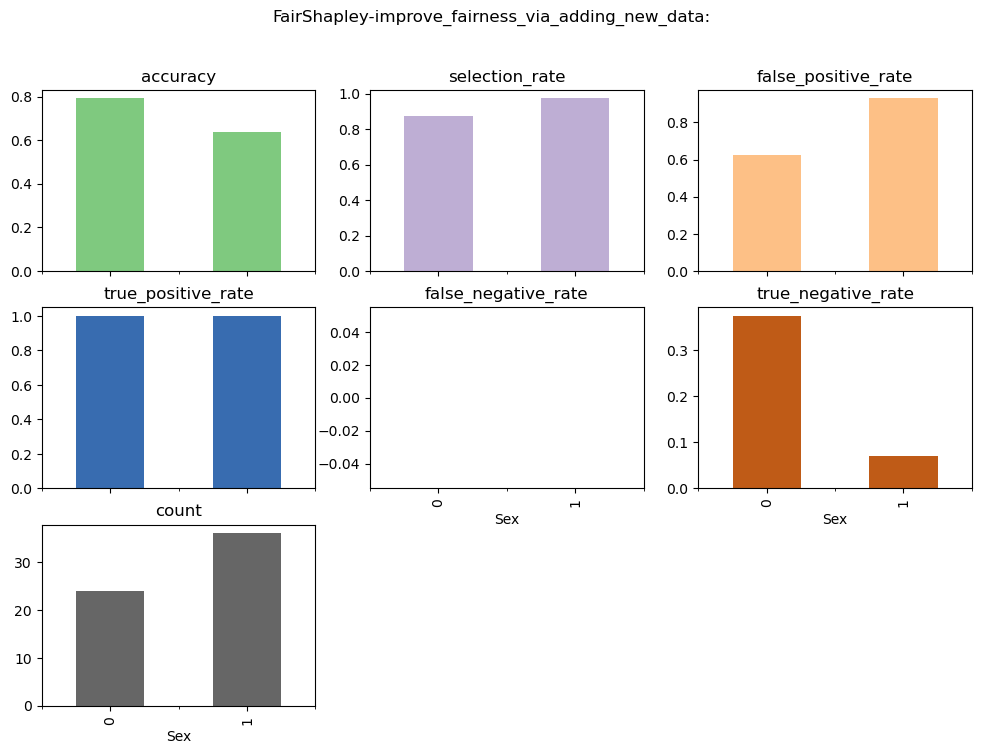

In [222]:
mf_original = MetricFrame(metrics=metrics,
                 y_true=y_test,
                 y_pred=y_pred_new,
                 sensitive_features=a_test)

print("Test set fairness metrics (after mitigation):")
mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="FairShapley-improve_fairness_via_adding_new_data:",
)
mf_original.by_group

In [ ]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
shap.summary_plot(fairness_shap_values, feature_names=X.columns)

In [ ]:
# Choose an instance to explain
instance_idx = 37  # You can change this index to any instance in the test set

# Plot the SHAP force plot for the chosen instance
shap.force_plot(
    fairness_explainer.expected_value, 
    fairness_shap_values[instance_idx], 
    pd.DataFrame(X_observe, columns=X.columns).reset_index(drop=True).loc[instance_idx]
)


In [ ]:
# Create a SHAP explainer
shap_explainer = shap.KernelExplainer(lambda x: model.predict_proba(x)[:, 1], X_unlabeled)

# Calculate SHAP values
shap_values = shap_explainer(X_observe)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, feature_names=X.columns)

In [ ]:
# Choose an instance to explain
instance_idx = 37  # You can change this index to any instance in the test set

# Plot the SHAP force plot for the chosen instance
shap.force_plot(
    shap_explainer.expected_value, 
    shap_values[instance_idx].values, 
    pd.DataFrame(X_observe, columns=X.columns).reset_index(drop=True).loc[instance_idx]
)
